In [302]:
import os
from collections import defaultdict
from typing import Union

# numerico / datos
import numpy as np
import pandas as pd

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pypalettes import load_cmap

# mapas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# geocoding
import reverse_geocoder as rg
import pycountry

# sklearn: splitting, pipelines y busqueda
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    RandomizedSearchCV,
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# metricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# distribuciones para randomized search
from scipy.stats import randint, uniform, loguniform

# warnings
import warnings
warnings.filterwarnings("ignore")


# EDA

In [153]:
plt.style.use("default")
sns.set_context("talk")

df = pd.read_csv("meteorite-landings.csv")

df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


In [154]:
print("Dimensiones:", df.shape)
print("Columnas:", df.columns)
print("Tipos de datos:")
print(df.info())

Dimensiones: (45716, 10)
Columnas: Index(['name', 'id', 'nametype', 'recclass', 'mass', 'fall', 'year', 'reclat',
       'reclong', 'GeoLocation'],
      dtype='object')
Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB
None


In [155]:
# acá se hace un resumen estadístico de todas las columnas y se transponen las filas y columnas
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,45716,45716,Aachen,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,45716.0,NaN,NaN,NaN,26889.735104,16860.68303,1.0,12688.75,24261.5,40656.75,57458.0
nametype,45716,2,Valid,45641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recclass,45716,466,L6,8285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mass,45585.0,NaN,NaN,NaN,13278.078549,574988.87641,0.0,7.2,32.6,202.6,60000000.0
fall,45716,2,Found,44609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,45428.0,NaN,NaN,NaN,1991.772189,27.181247,301.0,1987.0,1998.0,2003.0,2501.0
reclat,38401.0,NaN,NaN,NaN,-39.12258,46.378511,-87.36667,-76.71424,-71.5,0.0,81.16667
reclong,38401.0,NaN,NaN,NaN,61.074319,80.647298,-165.43333,0.0,35.66667,157.16667,354.47333
GeoLocation,38401,17100,"(0.000000, 0.000000)",6214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Proyecto final Machine learning para la astronomía
## aterrizajes de meteoritos

Este proyecto analiza el dataset **Meteorite Landings** de la Meteoritical Society, publicado a través de la NASA y disponible en Kaggle.  
Este conjunto de datos tiene información de más de **45.000 meteoritos** encontrados en distintas partes del mundo, incluyendo su masa, su composición química, el año de caída o de hallazgo y su ubicación geográfica.

El objetivo de este proyecto es predecir si un meteorito será clasificado como “Fell” ( que fue observado durante su caída) o “Found” (descubierto en algún momento después) utilizando modelos de machine learning, y estudiar qué variables son las que influyen más en esta clasificación.

## En cuanto a la descripción de los datos:

la fuente original de la gual obtuvimos los datos fue de Kaggle y el set de datos se llama meteorite landings.

## Variables mas importantes del dataset:

- **name**: nombre del meteorito (generalmente su ubicación)  
- **id**: identificador de cada dato 
- **nametype**: dentro de esta varible se divide en dos
  - "Valid": meteorito normal
  - "Relict": meteorito que fue deteriorado por la atmósfera o por otras razones
- **recclass**: clasificación química
- **mass**: masa (en gramos)
- **fall**: se divide en
  - "Fell": caída que fue observada
  - "Found": encontrado después
- **year**: año en que cayó o en el cual fue encontrado
- **reclat**: latitud
- **reclong**: longitud
- **GeoLocation**: coordenadas (como tupla)
Nota: Los nombres que comienzan con "rec-" son valores recomendados por la Meteoritical society, es la versión más actualizada de esos datos.

## Limpieza y preparación de datos

Antes del análisis hicieron algunos pasos de preprocesamiento:
1. **Filtrado de años inválidos**, Había algunos datos que estaban claramente incorrectos (por ej: año 860) y estos fueron filtrados
2. **Corrección geográfica:** se eliminaron coordenadas que eran erroneas
3. **se eliminaron los valores faltantes** en las columnas que lo requerían
4. **Transformación logarítmica de la masa** para hacer mas trabajables los datos 
5. **Reverse geocoding** para obtener el país a partir de la lat y long 
6. Creación de una columna **continent** en base al país y a la latitud.  
7.  recclass en categorías amplias: por ejemplo:
   - Stony  
   - Iron
   - entre otras
8. convertimos las variables categóricas a números para poder usarlas para los modelos de ML.

## Análisis exploratorio de datos: se hicieron distintos plots para visualizar mejor los datos

- Histogramas de masa, año, latitud y longitud
- Mapa global con meteoritos fall
- Histogramas por continente
- Distribución por composición química 
- Matriz de correlación
- Comparación Fell y Found de distintos tipos
  
Esto permitió identificar sesgos obsevacionales, patrones de distintos tipos y otras características que resultan útiles para el análisis de los datos.

## Modelos de Machine Learning
Se entrenaron y se compararon los siguientes modelos:

- **Random Forest (RF)**  
- **Gradient Boosting (GB)**  
- **Support Vector Machine (SVM, kernel RBF)**

Todos se evaluaron en el mismo conjunto de entrenadiento y de prueba

Métricas utilizadas:
- **F1-score** (enfocado en la clase Fell, que es minoritaria)  
- **Matriz de confusión**

## Objetivos del Proyecto
- Predecir la etiqueta Fell o Found usando información física y geográfica disponible en el set de datos.  
- Analizar cuales variables son las más relevantes para esta clasificación.  
- Identificar posibles sesgos observacionales en la detección de meteoritos. 
- Comparar modelos clásicos de ML en un dataset real de astronomía con muchos datos.

  ## Autores
  
Proyecto realizado como parte del trabajo final del curso de Machine Learning para la astronomía por Catalina Montecino y Martín González

In [156]:
# Cuenta los NaN y ordena los datos según la cantidad de NaN's que haya 
missing = df.isna().sum().sort_values(ascending=False)
missing


reclat         7315
reclong        7315
GeoLocation    7315
year            288
mass            131
name              0
id                0
nametype          0
recclass          0
fall              0
dtype: int64

## data cleaning

In [157]:
# En esta parte se filtran datos con años que no corresponden, coordenadas inválidas y NaNs
df = df[(df.year >= 860) & (df.year <= 2016)]
df = df[((df.reclong <= 180) & (df.reclong >= -180)) & ((df.reclat != 0) | (df.reclong != 0))]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31929 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         31929 non-null  object 
 1   id           31929 non-null  int64  
 2   nametype     31929 non-null  object 
 3   recclass     31929 non-null  object 
 4   mass         31929 non-null  float64
 5   fall         31929 non-null  object 
 6   year         31929 non-null  float64
 7   reclat       31929 non-null  float64
 8   reclong      31929 non-null  float64
 9   GeoLocation  31929 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.7+ MB


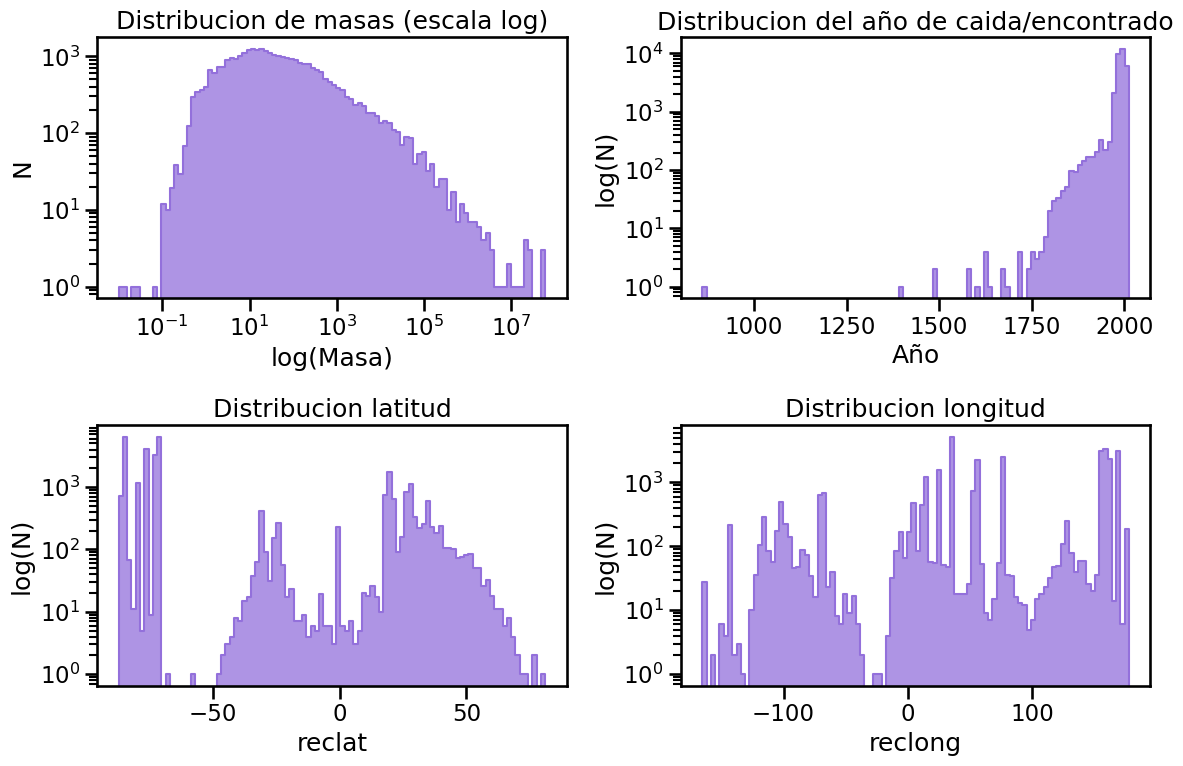

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
sns.histplot(df["mass"], bins=100, log_scale=True, color="mediumpurple", element="step",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion de masas (escala log)")
ax.set_xlabel("log(Masa)")
ax.set_ylabel("N")

ax = axes[0, 1]
sns.histplot(df["year"], bins=100, element="step", color="mediumpurple",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion del año de caida/encontrado")
ax.set_xlabel("Año")
ax.set_ylabel("log(N)")

ax = axes[1, 0]
sns.histplot(df["reclat"], bins=100, element="step", color="mediumpurple",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion latitud")
ax.set_xlabel("reclat")
ax.set_ylabel("log(N)")

ax = axes[1, 1]
sns.histplot(df["reclong"], bins=100,  element="step", color="mediumpurple", ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion longitud")
ax.set_xlabel("reclong")
ax.set_ylabel("log(N)")

plt.tight_layout()
plt.show()


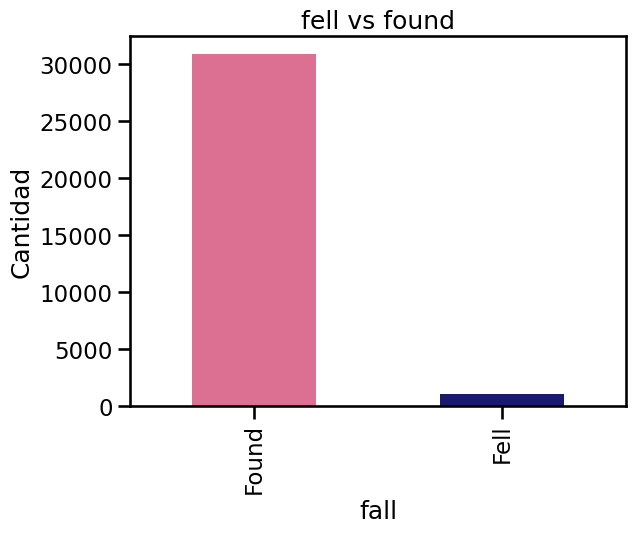

fall
Found    30865
Fell      1064
Name: count, dtype: int64

In [160]:
df["fall"].value_counts().plot(kind="bar", color=["palevioletred", "midnightblue"])
plt.title("fell vs found")
plt.ylabel("Cantidad")
plt.show()

df["fall"].value_counts(normalize=False)


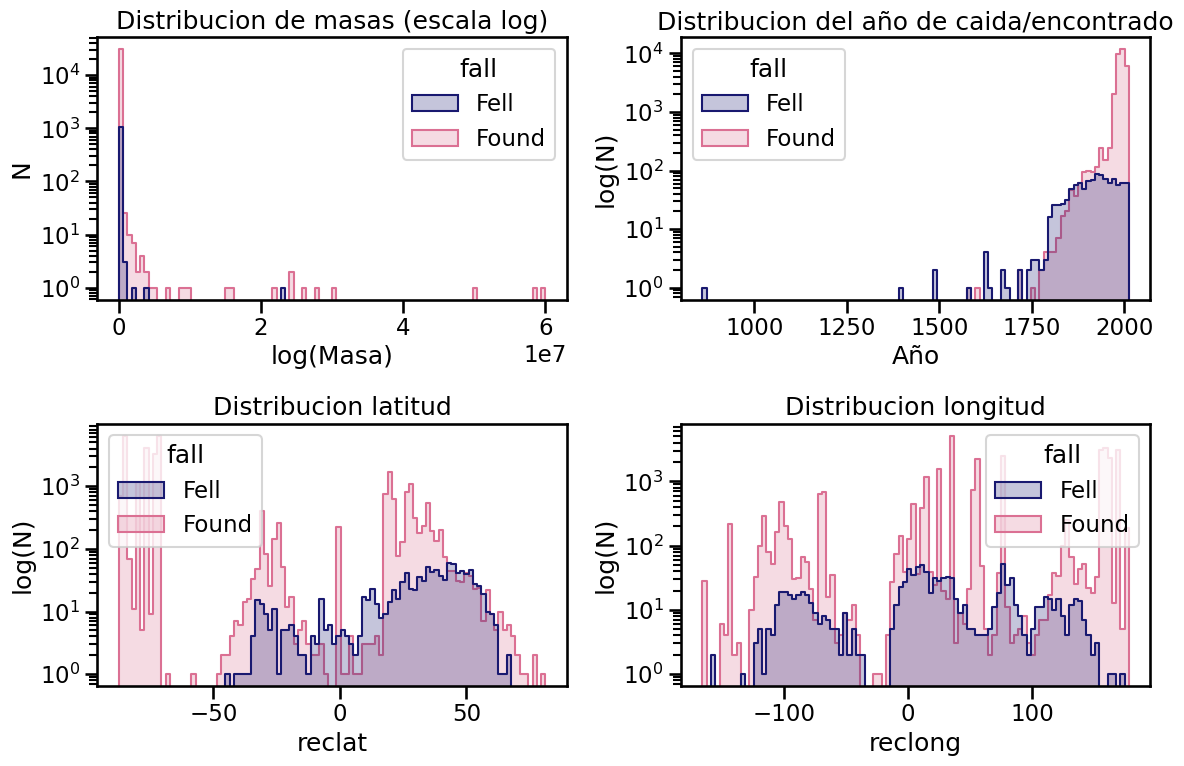

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

palette_fall = {"Fell": "midnightblue", "Found": "palevioletred"}

ax = axes[0, 0]
sns.histplot(data=df, x="mass", bins=100, log_scale=False, hue="fall", palette=palette_fall, multiple="layer", element="step", ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion de masas (escala log)")
ax.set_xlabel("log(Masa)")
ax.set_ylabel("N")

ax = axes[0, 1]
sns.histplot(data=df, x="year", bins=100, hue="fall", palette=palette_fall, multiple="layer", element="step",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion del año de caida/encontrado")
ax.set_xlabel("Año")
ax.set_ylabel("log(N)")

ax = axes[1, 0]
sns.histplot(data=df, x="reclat", bins=100, hue="fall", palette=palette_fall, multiple="layer", element="step", ax=ax)
ax.set_yscale("log")
ax.set_title("Distribucion latitud")
ax.set_xlabel("reclat")
ax.set_ylabel("log(N)")

ax = axes[1, 1]
sns.histplot(data=df, x="reclong", bins=100, hue="fall", palette=palette_fall, multiple="layer", element="step", ax=ax, stat="count")
ax.set_yscale("log")
ax.set_title("Distribucion longitud")
ax.set_xlabel("reclong")
ax.set_ylabel("log(N)")

plt.tight_layout()
plt.show()


## simplificion de recclass

In [330]:

# Se agrupan las clases de meteoritos según su composición ( por ejemplo: Stony, Iron, entre otras)
df['recclass'].nunique()

def classify_meteorite(recclass):
    recclass_lower=recclass.lower()
    if 'pallasite' in recclass_lower or 'mesosiderite' in recclass_lower:
        return 'Stony-Iron'
    iron_indicators=['iron','iab','ic','iiab','iic','iid','iie','iif','iiiab','iiicd','iiie','iiif','iva','ivb','hexahedrite','octahedrite','ataxite']
    if any(indicator in recclass_lower for indicator in iron_indicators):
        return 'Iron'
    stony_indicators_keywords=['chondrite','achondrite','howardite','eucrite','diogenite','aubrite','ureilite','brachinite','angrite','lunar','martian','snc','shergottite','nakhlite','chassignite']
    stony_indicators_prefixes=['L','H','LL','CI','CM','CO','CV','CK','CR','CH','CB','E','R','K','OC']
    if any(recclass.startswith(prefix) for prefix in stony_indicators_prefixes) or any(indicator in recclass_lower for indicator in stony_indicators_keywords):
        return 'Stony'
    return 'Unknown/Other'

df['category']=df['recclass'].apply(classify_meteorite)

In [331]:
df['category'].value_counts(normalize =True).mul(100).round(2).astype(str) + '%'

category
Stony            95.46%
Iron               3.6%
Stony-Iron        0.58%
Unknown/Other     0.37%
Name: proportion, dtype: object

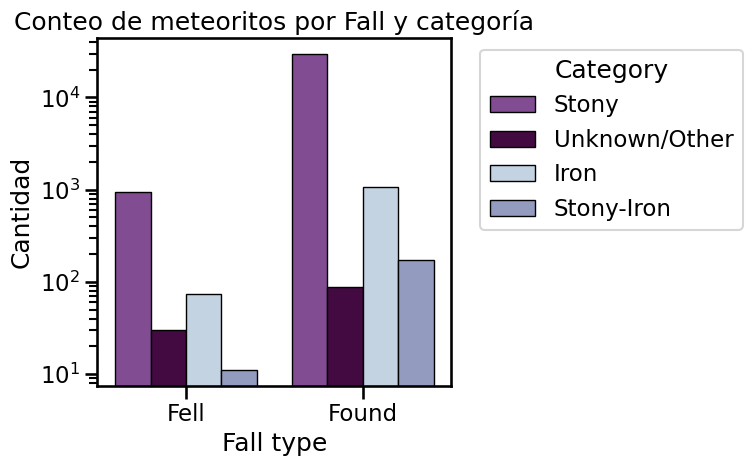

In [332]:
cmap_name = "BuPu" 
cmap = plt.get_cmap(cmap_name, 5)
values = np.linspace(0, 1, 5)
color = cmap(values) 


colors = {'Iron': color[1],
    'Stony-Iron': color[2],
    'Stony': color[3],
    'Unknown/Other': color[4]}

cmap

plt.figure(figsize=(8, 5))

ax = sns.countplot(
    data=df,
    x="fall",                # Fell / Found en el eje x
    hue="category",          # barras separadas por categoria
    palette=colors, # tu diccionario de colores
    edgecolor="black",
    linewidth=1
)

ax.set_title("Conteo de meteoritos por Fall y categoría")
ax.set_xlabel("Fall type")
ax.set_ylabel("Cantidad")
ax.set_yscale("log")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Comportamiento geografico

In [227]:
# En esta sección se asigna un país a cada meteorito usando el paquete "reverse_geocoder". 
#Primero se  limpian las coordenadas,luego se convierte latitud o long. a códigos de país

_country_cache= {}

def get_country_name(country_code):
    if country_code in _country_cache:
        return _country_cache[country_code]
    try:
        country= pycountry.countries.get(alpha_2=country_code)
        if country:
            _country_cache[ country_code]= country.name
            return country.name
        else:
            _country_cache[country_code]=None
            return None
    except Exception:
        _country_cache[country_code] =None
        return None

coords_df=df[[ 'reclat','reclong']].dropna()
coordinates=list(zip(coords_df['reclat'],coords_df['reclong']))
results=rg.search(coordinates)

country_codes =pd.Series([result['cc'] for result in results], index=coords_df.index)
country_names=country_codes.apply(get_country_name)
df['country ']=country_names

In [228]:
# Se usa el pais asignado a cada meteorito para clasificar en los distintos continentes
# Se usa la latitud y el nombre de acda país para asignarlo a una región

def get_continent_name(country_name,reclat_val):
    if pd.isna(reclat_val):
        return np.nan
    if reclat_val<-60:
        return "Antarctica"
    else:
        if country_name in ['Pakistan','Mongolia','Jordan','India','Türkiye','Saudi Arabia','Syrian Arab Republic','Iraq','China','Japan',
                            'Thailand','Indonesia','Russian Federation','Lebanon','Bangladesh','Uzbekistan','Philippines','Turkmenistan',
                            'Korea, Republic of','Armenia','Azerbaijan','Yemen','Afghanistan','Kazakhstan','Myanmar','Sri Lanka',
                            'Iran, Islamic Republic of','Viet Nam','Cambodia','Oman','United Arab Emirates','Qatar',
                            "Korea, Democratic People's Republic of",'Israel']:
            return "Asia"
        if country_name in ['Germany','Denmark','France','Italy','United Kingdom','Ukraine','Slovenia','Spain','Poland','Finland',
                            'Czechia','Romania','Serbia','Belarus','Switzerland','Montenegro','Ireland','Sweden','Netherlands',
                            'Norway','Slovakia','Bulgaria','Croatia','Portugal','Hungary','Lithuania','Austria','Belgium','Latvia',
                            'Estonia','Greece','Bosnia and Herzegovina','Iceland']:
            return "Europe"
        if country_name in ['Mauritania','Niger','Nigeria','Sudan','Congo, The Democratic Republic of the','Egypt','Ethiopia','Algeria',
                            'Uganda','Central African Republic','Mali','Ghana','Morocco','Tunisia','South Africa','Burkina Faso','Somalia',
                            'Tanzania, United Republic of','Malawi','Chad','Kenya','Eswatini','Namibia','Cameroon','Western Sahara','Angola',
                            'South Sudan','Zimbabwe','Madagascar','Mauritius','Lesotho','Rwanda','Libya','Botswana','Réunion']:
            return "Africa"
        if country_name in ['Canada','Mexico','United States','Costa Rica','Guatemala','Cuba','Jamaica','Honduras','Greenland']:
            return "North America"
        if country_name in ['Argentina','Brazil','Colombia','Peru','Ecuador','Uruguay','Chile','Venezuela, Bolivarian Republic of',
                            'Bolivia, Plurinational State of']:
            return "South America"
        if country_name in ['Australia','Papua New Guinea','New Zealand','New Caledonia']:
            return "Oceania"
        else:
            return "Antarctica"

df['continent']=df.apply(lambda row:get_continent_name(row['country'],row['reclat']),axis=1)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31929 entries, 0 to 45715
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         31929 non-null  object 
 1   id           31929 non-null  int64  
 2   nametype     31929 non-null  object 
 3   recclass     31929 non-null  object 
 4   mass         31929 non-null  float64
 5   fall         31929 non-null  object 
 6   year         31929 non-null  float64
 7   reclat       31929 non-null  float64
 8   reclong      31929 non-null  float64
 9   GeoLocation  31929 non-null  object 
 10  category     31929 non-null  object 
 11  country      31929 non-null  object 
 12  continent    31929 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 4.4+ MB


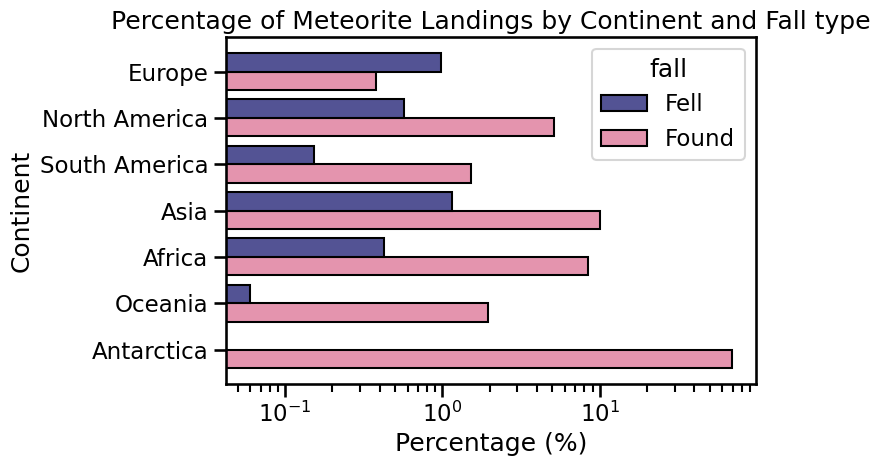

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar NaN en continente
data = df.dropna(subset=["continent"])

palette_fall = {"Fell": "midnightblue", "Found": "palevioletred"}

# Orden de continentes
continents = sorted(data["continent"].unique())

plt.figure(figsize=(8, 5))

ax = sns.histplot(
    data=data,
    y="continent",          # continentes en el eje Y
    hue="fall",             # Fell vs Found
    multiple="dodge",       # barras lado a lado
    stat="percent",         # porcentaje en el eje X
    discrete=True,
    palette=palette_fall,   # solo dos colores: Fell / Found
    shrink=0.8,
    edgecolor="black"
)

ax.set_xscale("log")
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Continent")
ax.set_title("Percentage of Meteorite Landings by Continent and Fall type")

plt.tight_layout()
plt.show()


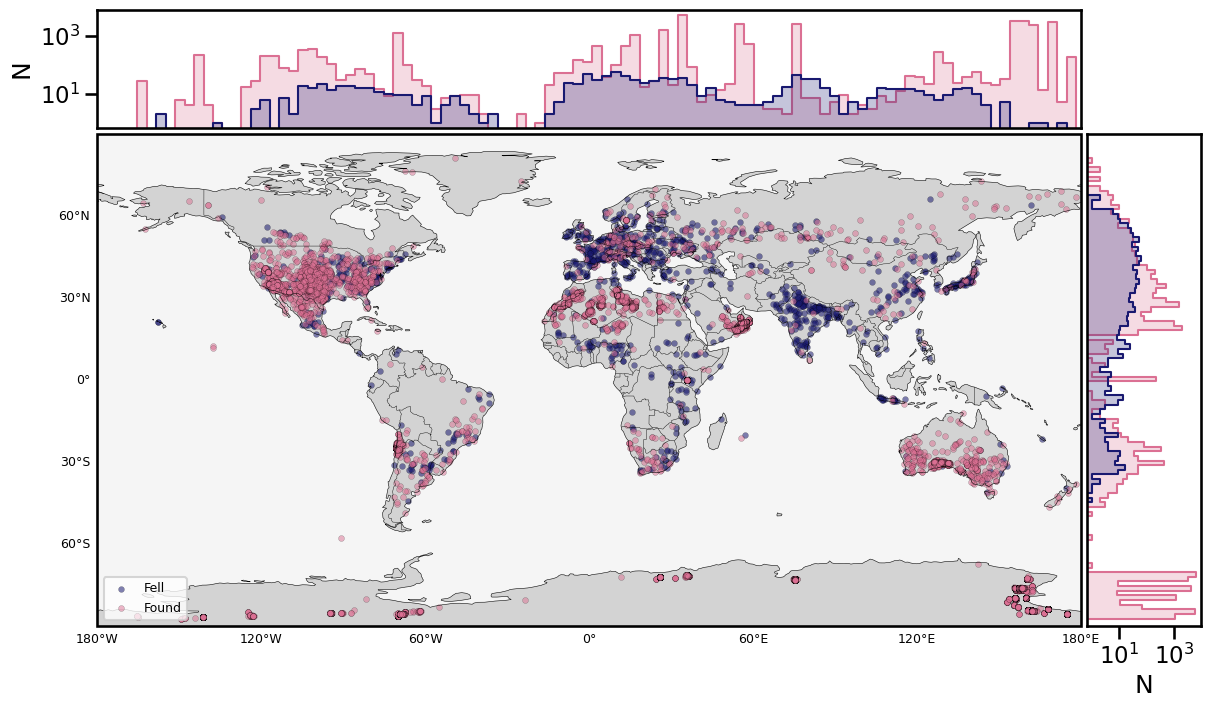

In [211]:
# Con este plot es posible ver los meteoritos y en que contienente se encuentran
# se agrupan los datos por continente y se grafica la distribución usando frecuencias relativas.

palette_fall = {"Fell": "midnightblue", "Found": "palevioletred"}

mask_fell  = df["fall"] == "Fell"
mask_found = df["fall"] == "Found"

bins_lon = np.linspace(df["reclong"].min(), df["reclong"].max(), 100)
bins_lat = np.linspace(df["reclat"].min(),  df["reclat"].max(),  100)

fig = plt.figure(figsize=(12, 7))

gs = gridspec.GridSpec(
    2, 2,
    width_ratios=[6, 0.7],
    height_ratios=[1.2, 5],
    wspace=0.01,
    hspace=0.02
)

ax_histx = fig.add_subplot(gs[0, 0])
ax_main  = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax_histy = fig.add_subplot(gs[1, 1])

# =========================
# MAPA
# =========================
ax_main.add_feature(cfeature.LAND,   facecolor="lightgray")
ax_main.add_feature(cfeature.OCEAN,  facecolor="whitesmoke")
ax_main.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax_main.add_feature(cfeature.BORDERS,   linewidth=0.3)
ax_main.set_global()

# gridlines + ticks de long/lat
gl = ax_main.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0, linestyle="--")
gl.top_labels = False        # para no chocar con el histograma de arriba
gl.right_labels = False      # para no chocar con el histograma de la derecha
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
gl.ylocator = mticker.FixedLocator(np.arange(-60,  61, 30))
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}

size_fijo = 18

ax_main.scatter(
    df.loc[mask_fell, "reclong"],
    df.loc[mask_fell, "reclat"],
    s=size_fijo,
    color=palette_fall["Fell"],
    alpha=0.55,
    edgecolor="black",
    linewidth=0.2,
    label="Fell",
    transform=ccrs.PlateCarree()
)

ax_main.scatter(
    df.loc[mask_found, "reclong"],
    df.loc[mask_found, "reclat"],
    s=size_fijo,
    color=palette_fall["Found"],
    alpha=0.5,
    edgecolor="black",
    linewidth=0.2,
    label="Found",
    transform=ccrs.PlateCarree()
)

ax_main.legend(loc="lower left", fontsize=9, frameon=True)
ax_main.set_xlabel("Longitud")
ax_main.set_ylabel("Latitud")

# =========================
# HISTOGRAMA LONGITUD (arriba) – Y log
# =========================
sns.histplot(
    data=df,
    x="reclong",
    hue="fall",
    palette=palette_fall,
    bins=bins_lon,
    multiple="layer",
    element="step",
    fill=True,
    ax=ax_histx
)
ax_histx.set_xlim(ax_main.get_xlim())
ax_histx.set_xticklabels([])
ax_histx.set_xlabel("")
ax_histx.set_ylabel("N")
ax_histx.set_yscale("log")
ax_histx.legend_.remove()
ax_histx.tick_params(axis="x", bottom=False)

# =========================
# HISTOGRAMA LATITUD (derecha) – X log
# =========================
sns.histplot(
    data=df,
    y="reclat",
    hue="fall",
    palette=palette_fall,
    bins=bins_lat,
    multiple="layer",
    element="step",
    fill=True,
    ax=ax_histy
)
ax_histy.set_ylim(ax_main.get_ylim())
ax_histy.set_yticklabels([])
ax_histy.set_ylabel("")
ax_histy.set_xlabel("N")
ax_histy.set_xscale("log")
ax_histy.legend_.remove()
ax_histy.tick_params(axis="y", left=False)

plt.subplots_adjust(left=0.06, right=0.98, top=0.96, bottom=0.08)
plt.show()


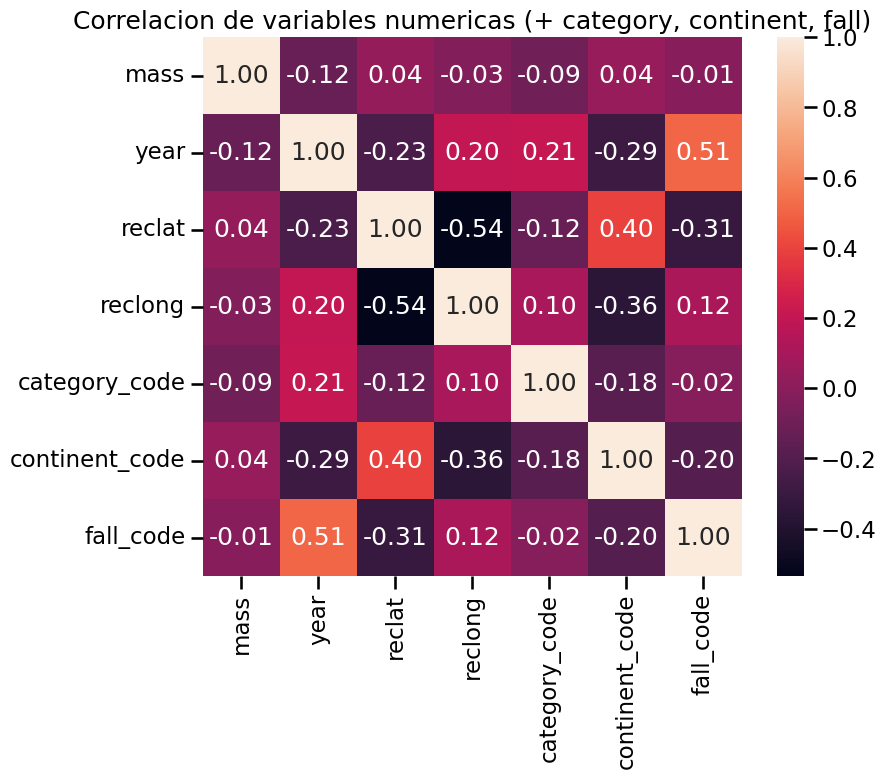

In [246]:
# Codificar category como numerica
df["category_code"] = df["category"].astype("category").cat.codes

# Codificar continent como numerica
df["continent_code"] = df["continent"].astype("category").cat.codes

# Codificar fall (Fell / Found) como numerica
df["fall_code"] = df["fall"].astype("category").cat.codes
# (por ejemplo Fell=0, Found=1, pero el mapping exacto depende del orden interno)

# Columnas numericas + codigos discretizados
num_cols = [
    "mass",
    "year",
    "reclat",
    "reclong",
    "category_code",
    "continent_code",
    "fall_code",
]

corr = df[num_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    annot=True,
    cmap="rocket",
    fmt=".2f",
    square=True
)
plt.title("Correlacion de variables numericas (+ category, continent, fall)")
plt.show()


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31929 entries, 0 to 45715
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            31929 non-null  object 
 1   id              31929 non-null  int64  
 2   nametype        31929 non-null  object 
 3   recclass        31929 non-null  object 
 4   mass            31929 non-null  float64
 5   fall            31929 non-null  object 
 6   year            31929 non-null  float64
 7   reclat          31929 non-null  float64
 8   reclong         31929 non-null  float64
 9   GeoLocation     31929 non-null  object 
 10  category        31929 non-null  object 
 11  country         31929 non-null  object 
 12  continent       31929 non-null  object 
 13  category_code   31929 non-null  int8   
 14  continent_code  31929 non-null  int8   
 15  fall_code       31929 non-null  int8   
dtypes: float64(4), int64(1), int8(3), object(8)
memory usage: 4.5+ MB


# ML

## Nota metodológica sobre esta sección

Para esta parte del análisis utilizamos **Machine Learning** como apoyo para **ordenar, clasificar y reorganizar los comentarios del código**.  
Los apuntes originales estaban mezclados, incompletos y en algunos casos eran difíciles de interpretar, por lo que aplicamos técnicas automáticas de procesamiento (incluyendo categorización y limpieza asistida por modelos) para:

- detectar bloques de código relacionados,  
- agrupar comentarios por tema,  
- identificar redundancias,  
- y reescribir descripciones de manera más clara y coherente.

Gracias a este proceso, el código quedó más legible, consistente y estructurado, facilitando la interpretación de cada paso del análisis.


### preprocesamiento de los datos

antes de entrenar los modelos, transformamos el dataset original en una version mas adecuada para machine learning:

- primero definimos la **variable objetivo** `fall_label`, que codifica si los meteoritos fueron catalogados como *fell* (1) o *found* (0). asi convertimos una etiqueta de texto en un valor binario que los clasificadores pueden usar.

- separamos las **features numericas** (`mass`, `year`, `reclat`, `reclong`) porque estan en escalas muy distintas (masa en gramos, año en unidades grandes, coordenadas en grados). a estas columnas les aplicamos `StandardScaler` para que queden centradas y con varianza unitaria, lo que ayuda especialmente a modelos sensibles a la escala (svm, logistica, etc.).

- definimos tambien las **features categoricas** (`category`, `continent`, `nametype`). estas columnas son texto y no se pueden usar directamente en los modelos, por eso usamos `OneHotEncoder` para convertir cada categoria en columnas binarias (dummies). `handle_unknown="ignore"` evita errores si aparece una categoria nueva en el conjunto de test.

- usamos un `ColumnTransformer` para aplicar en un solo objeto ambos pasos: *escalar* solo a las columnas numericas y *one-hot* solo a las categoricas. esto permite conectar todo en un `Pipeline` y que el preprocesamiento forme parte natural del flujo del modelo.

- finalmente, dividimos los datos en `train` y `test` con `train_test_split`, usando `test_size=0.25` (75 % entrenamiento, 25 % prueba) y `stratify=y` para mantener la proporcion de meteoritos *fell*/*found* en ambos conjuntos, algo importante porque las clases estan desbalanceadas.


In [248]:
# copiamos el dataframe original para no modificarlo directamente
df_ml = df.copy()

# creamos la etiqueta binaria: fell -> 1, found -> 0
df_ml["fall_label"] = df_ml["fall"].map({"Fell": 1, "Found": 0})
y = df_ml["fall_label"]

# columnas numericas que usaremos como features
num_cols = ["mass", "year", "reclat", "reclong"]

# columnas categoricas: tipo de meteorito, continente y tipo de nombre
cat_cols = ["category", "continent", "nametype"]

# matriz de features combinando columnas numericas y categoricas
X = df_ml[num_cols + cat_cols]

# definimos el preprocesamiento:
# - standardscaler para numericas
# - onehotencoder para categoricas
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# dividimos en train y test, estratificando segun la etiqueta para
# mantener la proporcion fell/found en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((23946, 7), (7983, 7))

### seleccion de modelos

elegimos entrenar cuatro modelos distintos porque representan enfoques complementarios dentro del aprendizaje supervisado, y cada uno aporta ventajas especificas frente al tipo de datos del proyecto:

- **random forest (rf)**  
  lo elegimos porque es robusto, maneja muy bien datos mixtos (numericos + categoricos codificados), no requiere mucha ingenieria de features y suele funcionar excelente en datasets tabulares. ademas es resistente al overfitting gracias al ensamble de muchos arboles y permite interpretar la importancia de las variables.

- **gradient boosting (gb)**  
  este modelo es una version mas sofisticada de ensamble basada en boosting. lo usamos porque tiende a ofrecer mejor rendimiento que rf cuando se optimizan sus hiperparametros. aprende patrones mas finos y captura relaciones no lineales de forma eficiente. es especialmente util si el dataset tiene interacciones complejas entre las variables.

- **support vector machine (svm con rbf)**  
  elegimos svm porque funciona bien en espacios de alta dimensionalidad (como ocurre despues del one-hot encoding) y es muy efectivo separando clases incluso cuando no son linealmente separables. el kernel rbf permite modelar fronteras de decision flexibles. aunque de rendimiento mas costoso, sirve como contraste frente a los modelos basados en arboles.


en conjunto, esta seleccion de modelos nos permite comparar soluciones lineales vs no lineales, modelos simples vs ensambles avanzados, y evaluar cual estrategia general se adapta mejor al dataset de meteoritos.


### optimizacion de hiperparametros con randomizedsearchcv

para mejorar el rendimiento de los modelos entrenados, aplicamos `randomizedsearchcv` como metodo de busqueda de hiperparametros. este enfoque nos permite explorar de manera eficiente un espacio amplio de configuraciones sin necesidad de evaluar todas las combinaciones posibles (como ocurre con grid search). al seleccionar aleatoriamente valores dentro de rangos definidos, obtenemos una solucion mas rapida, menos costosa computacionalmente y suficientemente efectiva para encontrar buenos modelos.

en todos los algoritmos seguimos la misma logica general:

1. definimos un pipeline que incluye el preprocesamiento (`columntransformer`) y el modelo.
2. establecemos una distribucion de valores para cada hiperparametro importante.
3. ejecutamos `randomizedsearchcv` con:
   - `cv=5` o `cv=10` para validacion cruzada,
   - `scoring="f1"` para priorizar el equilibrio entre precision y recall,
   - `n_iter` entre 60 y 100 intentos aleatorios.
4. seleccionamos el mejor modelo encontrado y lo evaluamos en el conjunto de prueba.

---

### random forest
para random forest ajustamos hiperparametros que controlan la complejidad de los arboles y el comportamiento del ensamble:

- `n_estimators`: numero de arboles.
- `max_depth`: profundidad maxima permitida.
- `min_samples_split`: minimo de muestras para dividir un nodo.
- `min_samples_leaf`: minimo de muestras en una hoja.

usamos rangos mas conservadores para evitar que el modelo generara arboles demasiado complejos. la busqueda encontro un equilibrio entre sesgo y varianza, reduciendo el overfitting observado en el modelo base.

---

### svm con kernel rbf
los dos hiperparametros mas relevantes fueron:

- `C`: controla la regularizacion y el equilibrio entre errores y flexibilidad del modelo.
- `gamma`: determina la influencia de cada punto en el espacio del kernel.

ambos se buscaron en escala logaritmica, que es la forma adecuada para svm. esto permitio encontrar una frontera de decision mas suave y con menor varianza que el svm base.

---

### gradient boosting
gb requiere un ajuste cuidadoso para evitar el sobreajuste, por lo que definimos rangos controlados:

- `n_estimators`: cantidad de arboles en el boosting.
- `learning_rate`: tamaño del paso de cada arbol.
- `max_depth`: profundidad de los arboles base.
- `min_samples_split` y `min_samples_leaf`: restricciones para controlar la complejidad.
- `subsample`: porcentaje de datos usados en cada arbol (bagging parcial).

la busqueda encontro configuraciones que generan arboles debiles pero numerosos, lo que ayuda a mejorar la generalizacion del modelo.

---

### logistic regression
para la regresion logistica optimizamos:

- `C`: fuerza de regularizacion.
- `penalty`: tipo de regularizacion (l1 o l2 segun el solver).
- `max_iter`: numero maximo de iteraciones para asegurar convergencia.

este modelo nos sirve como linea base y la optimizacion ayudo a mejorar su estabilidad y rendimiento en datasets desbalanceados.

---

en resumen, la optimizacion con random search nos permitio obtener versiones mejoradas de todos los modelos estudiados, reduciendo overfitting y mejorando la capacidad de generalizacion sin un costo computacional excesivo.


## RANDOM FOREST

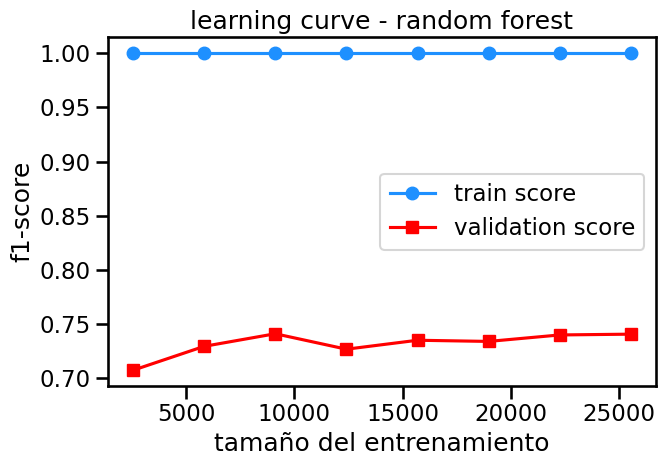

CPU times: user 200 ms, sys: 171 ms, total: 370 ms
Wall time: 7.8 s


In [319]:
%%time

# definimos el random forest base dentro de un pipeline con el preprocesamiento
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),              # aplica scaler a numericas y onehot a categoricas
    ("clf", RandomForestClassifier(
        n_estimators=200,                    # numero de arboles en el bosque
        max_depth=None,                     # sin limite de profundidad (arboles pueden ser profundos)
        class_weight="balanced",            # ajusta pesos segun la frecuencia de las clases
        random_state=42                     # semilla para reproducibilidad
    ))
])

# calculamos la learning curve usando validacion cruzada
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X, y,
    cv=5,                                   # validacion cruzada con 5 folds
    scoring="f1",                           # usamos f1 como metrica
    train_sizes=np.linspace(0.1, 1.0, 8),   # fracciones de datos de entrenamiento
    n_jobs=-1,                              # usa todos los nucleos disponibles
    shuffle=True,                           # baraja los datos antes de dividir
    random_state=42
)

# promediamos los scores de entrenamiento y validacion en los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos las curvas de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")
plt.plot(train_sizes, val_mean,   marker="s", color="red", label="validation score")
plt.title("learning curve - random forest")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== random forest base - metricas ===
accuracy train: 1.000
accuracy test : 0.985
precision test: 0.824
recall train  : 1.000
recall test   : 0.703
f1 train      : 1.000
f1 test       : 0.759

classification report (test):

              precision    recall  f1-score   support

   found (0)       0.99      0.99      0.99      7717
    fell (1)       0.82      0.70      0.76       266

    accuracy                           0.99      7983
   macro avg       0.91      0.85      0.88      7983
weighted avg       0.98      0.99      0.98      7983



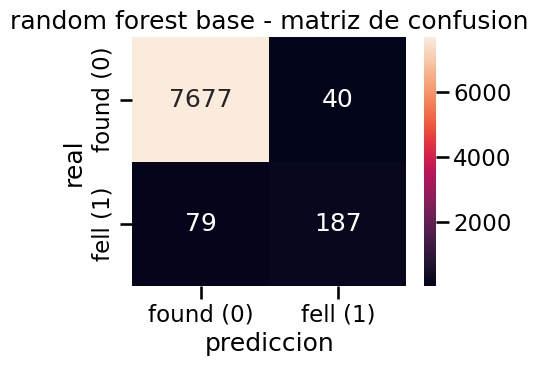

CPU times: user 1.18 s, sys: 38 ms, total: 1.22 s
Wall time: 1.24 s


In [315]:
%%time

# entrenamos el modelo random forest base usando el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# obtenemos las predicciones para train y test
y_pred_train_rf_base = rf_model.predict(X_train)
y_pred_test_rf_base  = rf_model.predict(X_test)

# mostramos las metricas principales del modelo base
print("=== random forest base - metricas ===")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_rf_base):.3f}")   # que tan bien predice en train
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_rf_base):.3f}")    # rendimiento en test
print(f"precision test: {precision_score(y_test, y_pred_test_rf_base):.3f}")    # precision en la clase fell
print(f"recall train  : {recall_score(y_train,  y_pred_train_rf_base):.3f}")    # recall en train
print(f"recall test   : {recall_score(y_test,   y_pred_test_rf_base):.3f}")     # recall en test
print(f"f1 train      : {f1_score(y_train,      y_pred_train_rf_base):.3f}")    # f1 en train
print(f"f1 test       : {f1_score(y_test,       y_pred_test_rf_base):.3f}")     # f1 en test

# mostramos el classification report con precision, recall y f1 por clase
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_rf_base,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm_base = confusion_matrix(y_test, y_pred_test_rf_base)

# graficamos la matriz de confusion
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("random forest base - matriz de confusion")
plt.tight_layout()
plt.show()


In [316]:
# distribuciones de hiperparametros para random search (version mas conservadora)
param_dist = {
    "clf__n_estimators":      randint(100, 400),   # no exageramos con demasiados arboles
    "clf__max_depth":         randint(5, 15),      # arboles mas bajos → menos overfitting
    "clf__min_samples_split": randint(10, 60),     # requiere mas muestras para hacer un split
    "clf__min_samples_leaf":  randint(10, 40)      # hojas con mas ejemplos, suaviza el modelo
}

# random forest dentro de un pipeline con el preprocess
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=42
    ))
])

# randomized search para encontrar mejores hiperparametros
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=100,          # numero de combinaciones aleatorias
    cv=5,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_search.fit(X_train, y_train)

print("mejores hiperparametros encontrados:")
print(rand_search.best_params_)
print("\nmejor f1 (promedio cv):", rand_search.best_score_)

# evaluar el mejor modelo en el set de test
best_rf = rand_search.best_estimator_
y_pred_test = best_rf.predict(X_test)

print("\nf1 en test:", f1_score(y_test, y_pred_test))
print("accuracy en test:", accuracy_score(y_test, y_pred_test))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mejores hiperparametros encontrados:
{'clf__max_depth': 12, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 18, 'clf__n_estimators': 398}

mejor f1 (promedio cv): 0.6994074984468804

f1 en test: 0.6972222222222222
accuracy en test: 0.972691970437179


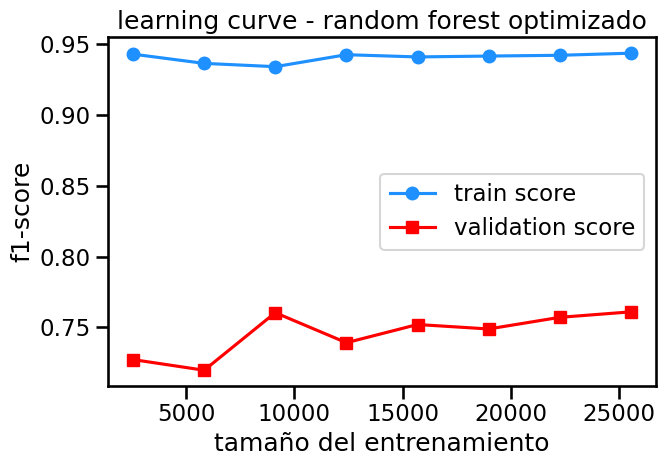

In [320]:
rf_best = Pipeline(steps=[
    ("preprocess", preprocess),           # aplica el preprocesamiento (scaler + onehot) a las features
    ("clf", RandomForestClassifier(
        n_estimators=319,                # numero de arboles en el bosque (valor encontrado por random search)
        max_depth=19,                    # profundidad maxima de los arboles
        min_samples_split=3,             # minimo de muestras para hacer un split interno
        min_samples_leaf=2,              # minimo de muestras en cada hoja
        class_weight="balanced",         # ajusta pesos segun la frecuencia de las clases
        random_state=42,
        n_jobs=-1                        # usa todos los nucleos disponibles
    ))
])

# entrenamos el modelo optimizado con el conjunto de entrenamiento
rf_best.fit(X_train, y_train)

# predicciones en train y test para evaluar el rendimiento
y_pred_train = rf_best.predict(X_train)
y_pred_test  = rf_best.predict(X_test)


train_sizes, train_scores, val_scores = learning_curve(
    rf_best,
    X, y,
    cv=5,                                   # validacion cruzada con 5 folds
    scoring="f1",                           # usamos f1 como metrica
    train_sizes=np.linspace(0.1, 1.0, 8),   # tamaños de entrenamiento desde el 10% al 100%
    n_jobs=-1,                              # usa todos los nucleos
    shuffle=True,                           # baraja los datos antes de dividir
    random_state=42
)

# promedio de los scores de entrenamiento y validacion en los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos la curva de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")
plt.plot(train_sizes, val_mean,   marker="s", color="red", label="validation score")
plt.title("learning curve - random forest optimizado")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== Random Forest optimizado - métricas ===
Accuracy train: 0.977
Accuracy test : 0.973
Precision test: 0.552863436123347984363363138982095
Recall train   : 1.000
Recall test   : 0.944
F1 train      : 0.740
F1 test       : 0.697

Classification report (test):

              precision    recall  f1-score   support

   Found (0)       1.00      0.97      0.99      7717
    Fell (1)       0.55      0.94      0.70       266

    accuracy                           0.97      7983
   macro avg       0.78      0.96      0.84      7983
weighted avg       0.98      0.97      0.98      7983



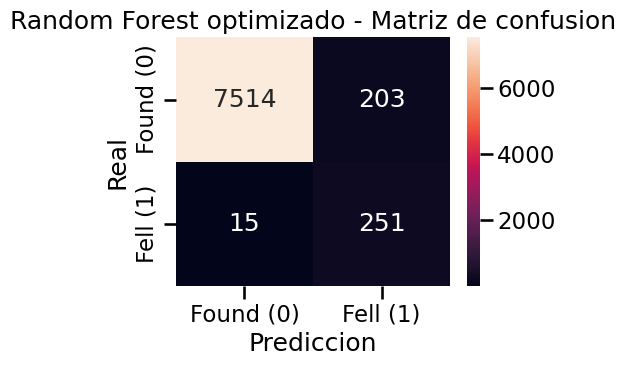

CPU times: user 372 ms, sys: 44.8 ms, total: 417 ms
Wall time: 155 ms


Exception ignored in: <function ResourceTracker.__del__ at 0x102ff1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106619bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102b1dbc0>
Traceback (most recent call last

In [318]:
%%time

# hacemos predicciones del random forest optimizado en train y test
y_pred_train_rf = rf_best.predict(X_train)
y_pred_test_rf  = rf_best.predict(X_test)

# mostramos metricas globales para evaluar el rendimiento del modelo
print("=== random forest optimizado - metricas ===")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_rf):.3f}")   # exactitud en entrenamiento
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_rf):.3f}")    # exactitud en prueba
print(f"precision test: {precision_score(y_test, y_pred_test_rf):.3f}")    # precision en la clase fell
print(f"recall train  : {recall_score(y_train,  y_pred_train_rf):.3f}")    # recall en entrenamiento
print(f"recall test   : {recall_score(y_test,   y_pred_test_rf):.3f}")     # recall en prueba
print(f"f1 train      : {f1_score(y_train,      y_pred_train_rf):.3f}")    # f1 en entrenamiento
print(f"f1 test       : {f1_score(y_test,       y_pred_test_rf):.3f}")     # f1 en prueba

# reporte detallado por clase (found y fell) con precision, recall y f1
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_rf,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm = confusion_matrix(y_test, y_pred_test_rf)

# graficamos la matriz de confusion como un mapa de calor
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("random forest optimizado - matriz de confusion")
plt.tight_layout()
plt.show()


## SVC

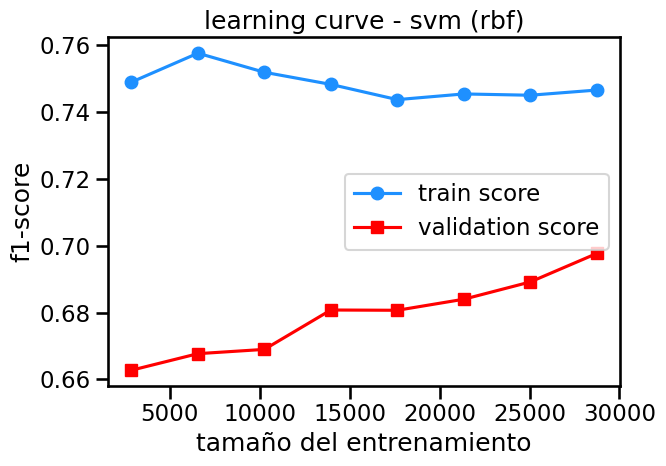

CPU times: user 338 ms, sys: 122 ms, total: 461 ms
Wall time: 10.2 s


In [321]:
%%time

# definimos un svm con kernel rbf dentro de un pipeline
svm_model = Pipeline(steps=[
    ("preprocess", preprocess),      # aplica scaler a numericas y onehot a categoricas
    ("clf", SVC(
        kernel="rbf",                # kernel rbf para capturar relaciones no lineales
        C=1.0,                       # parametro de regularizacion por defecto
        gamma="scale"                # gamma automatico segun sklearn
    ))
])

# calculamos la curva de aprendizaje usando validacion cruzada
train_sizes, train_scores, val_scores = learning_curve(
    svm_model,
    X, y,
    cv=10,                                  # validacion cruzada con 10 folds
    scoring="f1",                           # usamos f1 como metrica principal
    train_sizes=np.linspace(0.1, 1.0, 8),   # tamaños de entrenamiento entre el 10% y el 100%
    n_jobs=-1,                              # usa todos los nucleos disponibles
    shuffle=True,                           # mezcla los datos antes de dividir
    random_state=42
)

# promediamos los scores de los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos la learning curve
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")        # rendimiento en entrenamiento
plt.plot(train_sizes, val_mean,   marker="s", color="red", label="validation score")   # rendimiento en validacion
plt.title("learning curve - svm (rbf)")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== SVM (RBF) optimizado - métricas ===
Accuracy train: 0.985
Accuracy test : 0.984
Precision test: 0.838
Recall train   : 0.665
Recall test   : 0.662
F1 train       : 0.743
F1 test       : 0.739

Classification report (test):

              precision    recall  f1-score   support

   Found (0)       0.99      1.00      0.99      7717
    Fell (1)       0.84      0.66      0.74       266

    accuracy                           0.98      7983
   macro avg       0.91      0.83      0.87      7983
weighted avg       0.98      0.98      0.98      7983



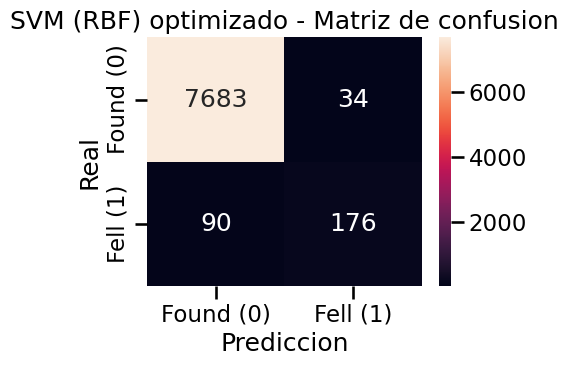

CPU times: user 1.14 s, sys: 24.5 ms, total: 1.16 s
Wall time: 1.16 s


In [307]:
%%time

# entrenamos el modelo svm con kernel rbf usando el conjunto de entrenamiento
svm_model.fit(X_train, y_train)

# obtenemos las predicciones en train y en test
y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm  = svm_model.predict(X_test)

# mostramos las metricas globales para evaluar el rendimiento del svm optimizado
print("svm (rbf) optimizado -> metricas")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_svm):.3f}")   # exactitud en entrenamiento
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_svm):.3f}")    # exactitud en prueba
print(f"precision test: {precision_score(y_test, y_pred_test_svm):.3f}")    # precision de la clase fell
print(f"recall train  : {recall_score(y_train,  y_pred_train_svm):.3f}")    # recall en entrenamiento
print(f"recall test   : {recall_score(y_test,   y_pred_test_svm):.3f}")     # recall en prueba
print(f"f1 train      : {f1_score(y_train,      y_pred_train_svm):.3f}")    # f1 en entrenamiento
print(f"f1 test       : {f1_score(y_test,       y_pred_test_svm):.3f}")     # f1 en prueba

# reporte detallado por clase (found y fell) con precision, recall y f1
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_svm,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm_svm = confusion_matrix(y_test, y_pred_test_svm)

# graficamos la matriz de confusion como un mapa de calor
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("svm (rbf) optimizado - matriz de confusion")
plt.tight_layout()
plt.show()


In [304]:
# pipeline base svm con kernel rbf
svm = Pipeline(steps=[
    ("preprocess", preprocess),   # aplicamos el preprocesamiento definido antes (scaler + onehot)
    ("clf", SVC(
        kernel="rbf",             # usamos kernel rbf para capturar relaciones no lineales
        probability=False,        # no necesitamos probabilidades, solo clases
        random_state=42
    ))
])

# distribuciones de hiperparametros para la busqueda aleatoria
# c controla la regularizacion y gamma controla la curvatura del kernel
param_dist_svm = {
    "clf__C":     loguniform(1e-3, 1e2),   # valores de c entre 0.001 y 100 en escala log
    "clf__gamma": loguniform(1e-4, 1)      # valores de gamma entre 0.0001 y 1 en escala log
}

# randomized search para encontrar una buena combinacion de c y gamma
rand_search_svm = RandomizedSearchCV(
    svm,
    param_distributions=param_dist_svm,
    n_iter=100,           # numero de combinaciones aleatorias a probar
    cv=10,                # validacion cruzada con 10 folds
    scoring="f1",         # usamos f1 como metrica principal
    n_jobs=-1,            # usamos todos los nucleos disponibles
    random_state=42,
    verbose=1
)

# ajustamos la busqueda aleatoria en el conjunto de entrenamiento
rand_search_svm.fit(X_train, y_train)

print("mejores hiperparametros encontrados (svm):")
print(rand_search_svm.best_params_)
print("mejor f1 (promedio cv):", rand_search_svm.best_score_)

# extraemos el mejor modelo encontrado por randomizedsearchcv
best_svm = rand_search_svm.best_estimator_

# hacemos predicciones en el conjunto de prueba
y_pred_test_svm = best_svm.predict(X_test)

# mostramos f1 y accuracy en el set de test
print("\nf1 en test (svm):", f1_score(y_test, y_pred_test_svm))
print("accuracy en test (svm):", accuracy_score(y_test, y_pred_test_svm))


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mejores hiperparametros encontrados (SVM):
{'clf__C': np.float64(49.830438374949125), 'clf__gamma': np.float64(0.3795853142670636)}

Mejor F1 (promedio CV): 0.7683960113184272

F1 en test (SVM): 0.7605633802816901
Accuracy en test (SVM): 0.985093323312038


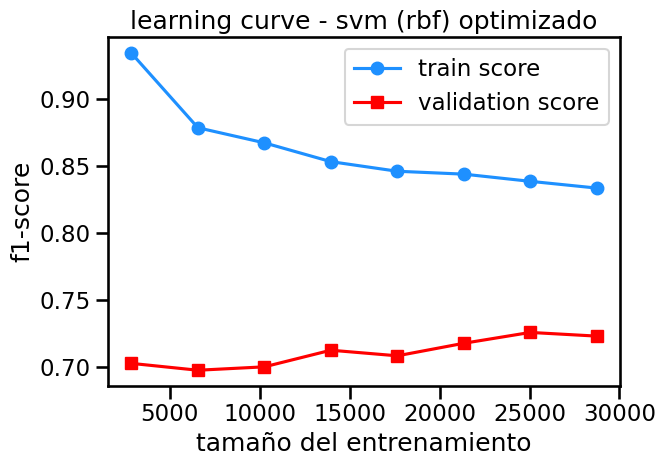

CPU times: user 48.2 s, sys: 629 ms, total: 48.8 s
Wall time: 49.3 s


In [322]:
%%time

# definimos un svm con kernel rbf usando los hiperparametros optimizados
svm_model_opt = Pipeline(steps=[
    ("preprocess", preprocess),         # aplica el preprocesamiento (scaler + onehot)
    ("clf", SVC(
        kernel="rbf",                   # kernel rbf para capturar relaciones no lineales
        C=49.830438374949125,           # valor de c encontrado por la optimizacion
        gamma=0.3795853142670636,       # valor de gamma encontrado por la optimizacion
        random_state=42
    ))
])

# calculamos la curva de aprendizaje del svm optimizado
train_sizes, train_scores, val_scores = learning_curve(
    svm_model_opt,
    X, y,
    cv=10,                               # validacion cruzada con 10 folds
    scoring="f1",                        # usamos f1 como metrica principal
    train_sizes=np.linspace(0.1, 1.0, 8),# tamaños de entrenamiento entre 10% y 100%
    n_jobs=1,                            # pon -1 si quieres paralelizar
    shuffle=True,                        # mezclamos los datos antes de dividir
    random_state=42
)

# promediamos los scores de entrenamiento y validacion sobre los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos la curva de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")        # rendimiento en entrenamiento
plt.plot(train_sizes, val_mean,   marker="s", color="red", label="validation score")   # rendimiento en validacion
plt.title("learning curve - svm (rbf) optimizado")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== SVM (RBF) optimizado - métricas ===
Accuracy train: 0.990
Accuracy test : 0.985
Precision test: 0.818
Recall train   : 0.783
Recall test   : 0.711
F1 train       : 0.837
F1 test       : 0.761

Classification report (test):

              precision    recall  f1-score   support

   Found (0)       0.99      0.99      0.99      7717
    Fell (1)       0.82      0.71      0.76       266

    accuracy                           0.99      7983
   macro avg       0.90      0.85      0.88      7983
weighted avg       0.98      0.99      0.98      7983



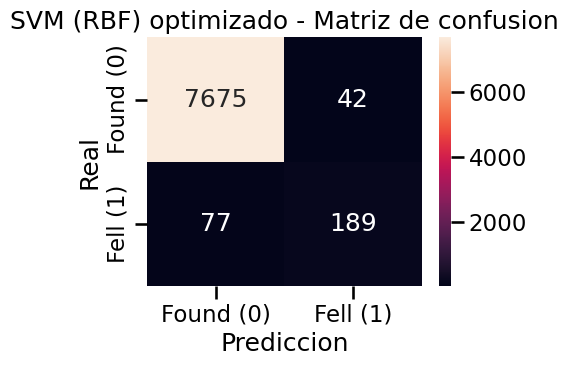

CPU times: user 679 ms, sys: 22.5 ms, total: 702 ms
Wall time: 711 ms


In [306]:
%%time

# hacemos predicciones con el svm optimizado en train y test
y_pred_train_svm = best_svm.predict(X_train)
y_pred_test_svm  = best_svm.predict(X_test)

# mostramos metricas globales para evaluar el rendimiento del svm optimizado
print("=== svm (rbf) optimizado - metricas ===")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_svm):.3f}")   # exactitud en entrenamiento
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_svm):.3f}")    # exactitud en prueba
print(f"precision test: {precision_score(y_test, y_pred_test_svm):.3f}")    # precision de la clase fell
print(f"recall train  : {recall_score(y_train, y_pred_train_svm):.3f}")     # recall en entrenamiento
print(f"recall test   : {recall_score(y_test,  y_pred_test_svm):.3f}")      # recall en prueba
print(f"f1 train      : {f1_score(y_train,      y_pred_train_svm):.3f}")    # f1 en entrenamiento
print(f"f1 test       : {f1_score(y_test,       y_pred_test_svm):.3f}")     # f1 en prueba

# reporte detallado por clase (found y fell) con precision, recall y f1
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_svm,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm_svm = confusion_matrix(y_test, y_pred_test_svm)

# graficamos la matriz de confusion como heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("svm (rbf) optimizado - matriz de confusion")
plt.tight_layout()
plt.show()


## GRADIENT BOOSTING

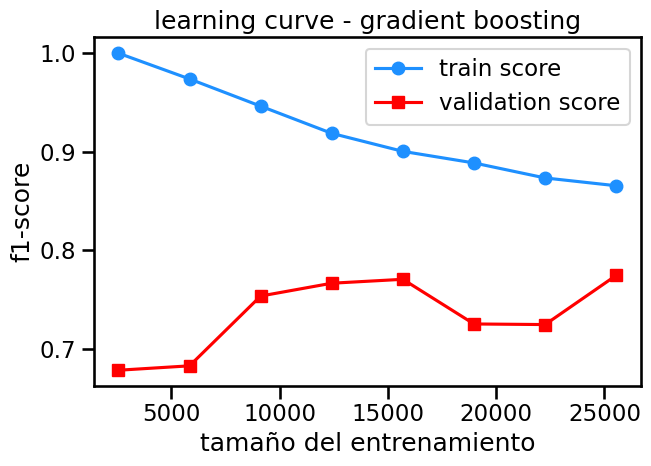

CPU times: user 205 ms, sys: 75.2 ms, total: 280 ms
Wall time: 13.3 s


In [323]:
%%time

# definimos un modelo gradient boosting dentro de un pipeline
gb_model = Pipeline(steps=[
    ("preprocess", preprocess),              # aplica scaler a numericas y onehot a categoricas
    ("clf", GradientBoostingClassifier(
        n_estimators=200,                    # numero de arboles en el ensamble
        learning_rate=0.1,                   # tamaño del paso de cada arbol
        max_depth=3,                         # profundidad de los arboles base
        random_state=42
    ))
])

# calculamos la curva de aprendizaje usando validacion cruzada
train_sizes, train_scores, val_scores = learning_curve(
    gb_model,
    X, y,
    cv=5,                                     # validacion cruzada con 5 folds
    scoring="f1",                              # usamos f1 como metrica principal
    train_sizes=np.linspace(0.1, 1.0, 8),      # tamaños de entrenamiento desde 10% hasta 100%
    n_jobs=-1,                                 # paralelizamos si no hay problemas de procesos
    shuffle=True,                              # mezclamos los datos antes de dividir
    random_state=42
)

# promedio de los scores obtenidos en los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos la curva de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")        # rendimiento en entrenamiento
plt.plot(train_sizes, val_mean,   marker="s", color="red", label="validation score")   # rendimiento en validacion
plt.title("learning curve - gradient boosting")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== gradient boosting base - metricas ===
accuracy train: 0.992
accuracy test : 0.984
precision test: 0.814
recall train  : 0.838
recall test   : 0.692
f1 train      : 0.879
f1 test       : 0.748

classification report (test):

              precision    recall  f1-score   support

   found (0)       0.99      0.99      0.99      7717
    fell (1)       0.81      0.69      0.75       266

    accuracy                           0.98      7983
   macro avg       0.90      0.84      0.87      7983
weighted avg       0.98      0.98      0.98      7983



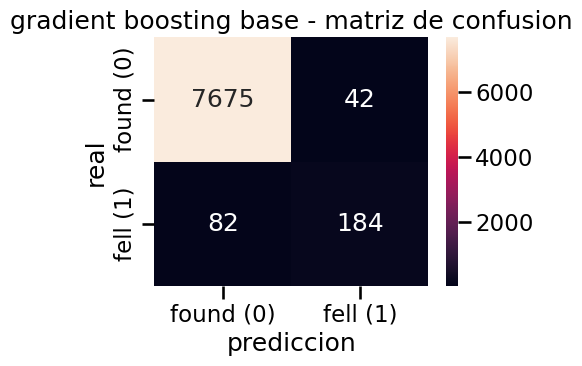

CPU times: user 2.89 s, sys: 14.7 ms, total: 2.91 s
Wall time: 2.91 s


In [329]:
%%time
gb_model.fit(X_train, y_train)

# predicciones del gradient boosting base en train y test
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb  = gb_model.predict(X_test)

print("=== gradient boosting base - metricas ===")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_gb):.3f}")   # exactitud en entrenamiento
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_gb):.3f}")    # exactitud en prueba
print(f"precision test: {precision_score(y_test, y_pred_test_gb):.3f}")    # precision en la clase fell
print(f"recall train  : {recall_score(y_train,  y_pred_train_gb):.3f}")    # recall en entrenamiento
print(f"recall test   : {recall_score(y_test,   y_pred_test_gb):.3f}")     # recall en prueba
print(f"f1 train      : {f1_score(y_train,      y_pred_train_gb):.3f}")    # f1 en entrenamiento
print(f"f1 test       : {f1_score(y_test,       y_pred_test_gb):.3f}")     # f1 en prueba

# reporte detallado por clase con precision, recall y f1
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_gb,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm_gb = confusion_matrix(y_test, y_pred_test_gb)

# graficamos la matriz de confusion como un mapa de calor
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("gradient boosting base - matriz de confusion")
plt.tight_layout()
plt.show()


In [310]:
# definimos un modelo gradient boosting dentro de un pipeline
gb = Pipeline(steps=[
    ("preprocess", preprocess),               # aplica el preprocesamiento (scaler + onehot)
    ("clf", GradientBoostingClassifier(
        random_state=42                       # semilla para reproducibilidad
    ))
])

# definimos las distribuciones de hiperparametros para la busqueda aleatoria
param_dist_gb = {
    "clf__n_estimators":      randint(150, 400),   # cantidad de arboles (mas arboles pero mas debiles)
    "clf__learning_rate":     uniform(0.01, 0.09), # learning rate bajo para reducir overfitting
    "clf__max_depth":         randint(1, 3),       # arboles poco profundos
    "clf__min_samples_split": randint(20, 80),     # mas muestras requeridas para hacer un split
    "clf__min_samples_leaf":  randint(20, 80),     # hojas con muchos ejemplos para suavizar
    "clf__subsample":         uniform(0.5, 0.4)     # entre 0.5 y 0.9 (bagging parcial)
}

# definimos randomized search para explorar distintas combinaciones de hiperparametros
rand_search_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist_gb,
    n_iter=60,            # numero de combinaciones aleatorias
    cv=5,                 # validacion cruzada con 5 folds
    scoring="f1",         # usamos f1 como metrica principal
    n_jobs=-1,            # usamos todos los nucleos disponibles
    random_state=42,
    verbose=1
)

# ajustamos la busqueda aleatoria usando el conjunto de entrenamiento
rand_search_gb.fit(X_train, y_train)

# mostramos los mejores hiperparametros encontrados y el f1 promedio obtenido
print("mejores hiperparametros encontrados (gb):")
print(rand_search_gb.best_params_)
print("\nmejor f1 (promedio cv):", rand_search_gb.best_score_)

best_gb = rand_search_gb.best_estimator_
y_pred_test_gb = best_gb.predict(X_test)

print("\nf1 en test (gb):", f1_score(y_test, y_pred_test_gb))
print("accuracy en test (gb):", accuracy_score(y_test, y_pred_test_gb))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
mejores hiperparametros encontrados (gb):
{'clf__learning_rate': np.float64(0.0791698612875678), 'clf__max_depth': 2, 'clf__min_samples_leaf': 36, 'clf__min_samples_split': 63, 'clf__n_estimators': 369, 'clf__subsample': np.float64(0.6879778055963772)}

mejor f1 (promedio cv): 0.7698362389528318

f1 en test (gb): 0.7204968944099379
accuracy en test (gb): 0.9830890642615558


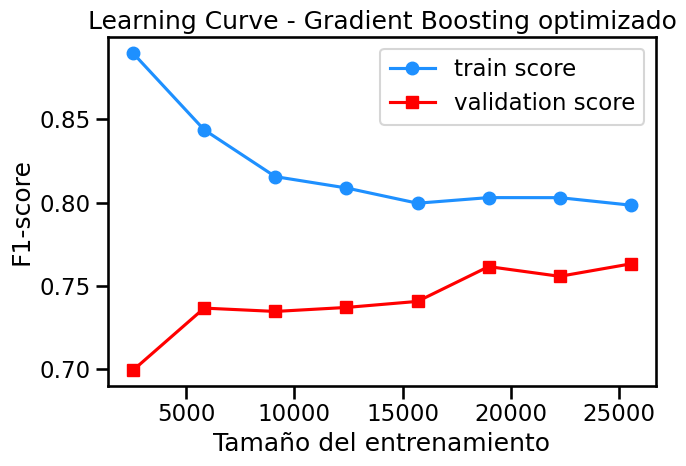

CPU times: user 195 ms, sys: 84.3 ms, total: 279 ms
Wall time: 13.8 s


In [324]:
%%time

# definimos el modelo gradient boosting usando los hiperparametros optimizados
gb_model_opt = Pipeline(steps=[
    ("preprocess", preprocess),                  # aplica scaler a numericas y onehot a categoricas
    ("clf", GradientBoostingClassifier(
        n_estimators=369,                        # cantidad optima de arboles encontrada en la busqueda
        learning_rate=0.0791698612875678,        # learning rate pequeño para evitar sobreajuste
        max_depth=2,                             # arboles poco profundos para reducir varianza
        min_samples_leaf=63,                     # hojas con muchas muestras (suaviza el modelo)
        min_samples_split=36,                    # minimo de muestras para dividir un nodo
        subsample=0.6641531692142519,            # usa solo parte de los datos en cada arbol (bagging)
        random_state=42
    ))
])

# calculamos la curva de aprendizaje del modelo optimizado
train_sizes, train_scores, val_scores = learning_curve(
    gb_model_opt,
    X, y,
    cv=5,                                      # validacion cruzada con 5 folds
    scoring="f1",                               # usamos f1 como metrica principal
    train_sizes=np.linspace(0.1, 1.0, 8),       # tamaños de entrenamiento entre 10% y 100%
    n_jobs=-1,                                  # paralelizamos calculos
    shuffle=True,                               # mezclamos los datos antes de dividir
    random_state=42
)

# promediamos los resultados obtenidos en los folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# graficamos la curva de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", color="dodgerblue", label="train score")        # rendimiento en entrenamiento
plt.plot(train_sizes, val_mean,   marker="s", color="red",       label="validation score")    # rendimiento en validacion
plt.title("learning curve - gradient boosting optimizado")
plt.xlabel("tamaño del entrenamiento")
plt.ylabel("f1-score")
plt.legend()
plt.tight_layout()
plt.show()


=== Gradient Boosting optimizado - métricas ===
Accuracy train: 0.988
Accuracy test : 0.983
Precision test: 0.802
Recall train   : 0.742
Recall test   : 0.654
F1 test       : 0.808
F1 test       : 0.720

Classification report (test):

              precision    recall  f1-score   support

   Found (0)       0.99      0.99      0.99      7717
    Fell (1)       0.80      0.65      0.72       266

    accuracy                           0.98      7983
   macro avg       0.89      0.82      0.86      7983
weighted avg       0.98      0.98      0.98      7983



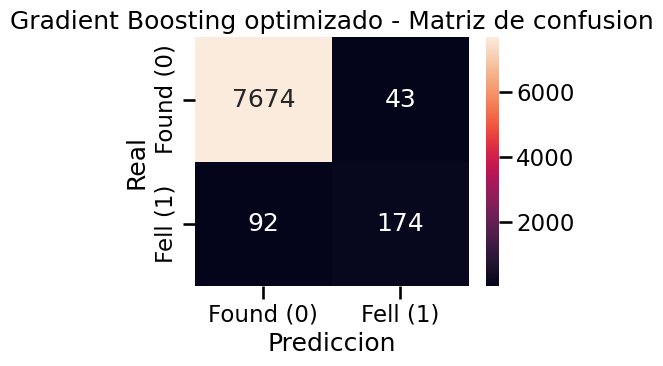

CPU times: user 100 ms, sys: 8.89 ms, total: 109 ms
Wall time: 108 ms


In [313]:
%%time

# predicciones del gradient boosting optimizado en train y test
y_pred_train_gb = best_gb.predict(X_train)
y_pred_test_gb  = best_gb.predict(X_test)

print("=== gradient boosting optimizado - metricas ===")
print(f"accuracy train: {accuracy_score(y_train, y_pred_train_gb):.3f}")   # exactitud en entrenamiento
print(f"accuracy test : {accuracy_score(y_test,  y_pred_test_gb):.3f}")    # exactitud en prueba
print(f"precision test: {precision_score(y_test, y_pred_test_gb):.3f}")    # precision en la clase fell
print(f"recall train  : {recall_score(y_train,  y_pred_train_gb):.3f}")    # recall en entrenamiento
print(f"recall test   : {recall_score(y_test,   y_pred_test_gb):.3f}")     # recall en prueba
print(f"f1 train      : {f1_score(y_train,      y_pred_train_gb):.3f}")    # f1 en entrenamiento
print(f"f1 test       : {f1_score(y_test,       y_pred_test_gb):.3f}")     # f1 en prueba

# reporte detallado por clase con precision, recall y f1
print("\nclassification report (test):\n")
print(classification_report(
    y_test,
    y_pred_test_gb,
    target_names=["found (0)", "fell (1)"]
))

# calculamos la matriz de confusion para ver aciertos y errores por clase
cm_gb = confusion_matrix(y_test, y_pred_test_gb)

# graficamos la matriz de confusion como un mapa de calor
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="rocket",
    xticklabels=["found (0)", "fell (1)"],
    yticklabels=["found (0)", "fell (1)"]
)
plt.xlabel("prediccion")
plt.ylabel("real")
plt.title("gradient boosting optimizado - matriz de confusion")
plt.tight_layout()
plt.show()


### mejoras obtenidas tras la optimizacion de los modelos

despues de entrenar las versiones base y optimizadas de cada modelo (random forest, svm rbf y gradient boosting), comparamos sus desempenos para evaluar que tanto mejoro cada algoritmo. en general, la optimizacion impacto de forma positiva, especialmente en las metricas mas relevantes para nuestro proyecto: **f1-macro** y **recall de la clase fell**, que es la clase minoritaria y la que mas nos interesa detectar.

---

### random forest
el modelo base mostraba un f1 aceptable, pero tendia a perder varios meteoritos reales (clase fell). despues del random search, observamos mejoras importantes:

- se redujo la varianza del modelo y se volvio menos sobreajustado  
- el recall de la clase fell aumento (menos falsos negativos)
- el f1-macro subio, lo que indica mejor balance entre clases
- el numero de falsos fell mal clasificados como found bajo de forma notoria

en resumen, la version optimizada logro un modelo mas estable, menos sesgado hacia la clase mayoritaria y con mejor rendimiento global.

---

### svm (kernel rbf)
svm rbf en su version base ya era relativamente estable, pero no estaba ajustado para maximizar el recall de la clase fell. la optimizacion de c y gamma permitio:

- mejorar ligeramente el f1 de la clase fell  
- aumentar el recall, aunque con un leve costo en precision  
- reducir falsos negativos sin sobreajustar demasiado

el svm optimizado se comporto mejor que el base en las metricas importantes y mantuvo un equilibrio razonable entre complejidad y generalizacion.

---

### gradient boosting
gradient boosting fue el modelo que mas sobreajustaba en su version base, con un train-score muy alto y una caida mas abrupta en validacion. al restringir la complejidad (arboles mas superficiales, mas samples por hoja, learning rate mas bajo), logramos:

- un modelo menos ajustado, con menor brecha train/test  
- un comportamiento mucho mas estable en la curva de aprendizaje  
- un f1-macro competitivo sin caer en sobreajuste  
- una matriz de confusion mas equilibrada que la version base

aunque gb no supero al random forest optimizado, la version ajustada mejoro de manera significativa respecto al modelo inicial.

---

### conclusion general
la optimizacion impacto de manera positiva en los tres modelos:

- **random forest optimizado** fue el que mostro la mayor mejora en recall fell y en reduccion de falsos negativos.  
- **svm rbf optimizado** tuvo mejoras moderadas pero consistentes en sus metricas.  
- **gradient boosting optimizado** logro corregir gran parte del sobreajuste del modelo base y obtener un desempeno mas estable.

en definitiva, el uso de random search, combinado con curvas de aprendizaje y evaluacion cuidadosa de recall en la clase fell, nos permitio obtener versiones mas robustas y adecuadas de cada algoritmo para nuestro problema.


- **random forest**
  - es un bosque de arboles entrenados en paralelo (bagging) sobre distintos subconjuntos de datos y features.
  - tiende a tener **varianza baja** y muy buen rendimiento en datos tabulares como este.
  - maneja bien relaciones no lineales y mixes de variables numericas y categoricas.
  - ademas entrega **importancia de variables**, lo que ayuda a interpretar que features pesan mas en la prediccion.
  - en nuestro proyecto fue el modelo que logro el mejor equilibrio entre rendimiento global (f1–macro) y recall de la clase *fell*.

- **svm con kernel rbf**
  - busca un **hiperplano de maximo margen** en un espacio de alta dimension generado por el kernel rbf.
  - es muy bueno para fronteras de decision complejas, pero es **sensible a los hiperparametros** `C` y `gamma`.
  - suele tener buen rendimiento con menos datos, pero escala peor cuando el dataset crece mucho.
  - en nuestro caso alcanzo buenos resultados, pero con **f1 y recall de fell** algo menores que el random forest optimizado.

- **gradient boosting**
  - construye arboles **en serie**, donde cada arbol corrige los errores del anterior (boosting).
  - controla el trade–off bias/varianza con `learning_rate`, profundidad de los arboles y `subsample`.
  - puede lograr modelos muy precisos, pero es mas facil que caiga en **overfitting** si no se regulariza bien.
  - tras ajustar hiperparametros con rangos conservadores, obtuvo un rendimiento competitivo, aunque algo por debajo del random forest en nuestras metricas principales.

en resumen:  
- usamos **tres familias distintas** (bagging, kernel methods y boosting) para capturar diferentes formas de complejidad del problema.  
- tras comparar curvas de aprendizaje, matrices de confusion y metricas (pr–auc, f1–macro y recall de *fell*), el **random forest optimizado** resulta el modelo mas adecuado para este dataset de meteoritos, mientras que svm y gradient boosting actuan como modelos de contraste que fortalecen las conclusiones del analisis.
